In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import tadasets
%matplotlib inline


start_time = time.time()
#Here we are just generating a torus
np.random.seed(2)
n_data = 25000
R = 5
r = 2
data = np.zeros((3, n_data))
s = np.random.rand(n_data)*2*np.pi
t = np.random.rand(n_data)*2*np.pi

data[0] = (R + r*np.cos(s))*np.cos(t)
data[1] = (R + r*np.cos(s))*np.sin(t)
data[2] = r*np.sin(s)
data += 0.1*np.random.randn(*data.shape)


#This is sampling to reduce the number of points that I have to work with
from sklearn.cluster import KMeans

def kmeans_downsampling(data, num_points):
    # Perform k-means clustering on the data
    kmeans = KMeans(n_clusters=num_points, random_state=0).fit(data)
    
    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_
    
    return centroids

# Set the desired number of points after downsampling
num_points = 100 #This seems to be a good sample size that keeps al of the important data

# Perform k-means downsampling on the data
x = kmeans_downsampling(data.T, num_points)


#First lets see what triangles actually exist, and if they do exist then we can mulitply




/Users/sofiamartinez/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


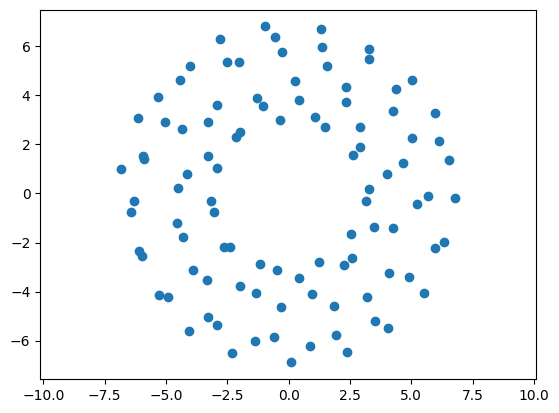

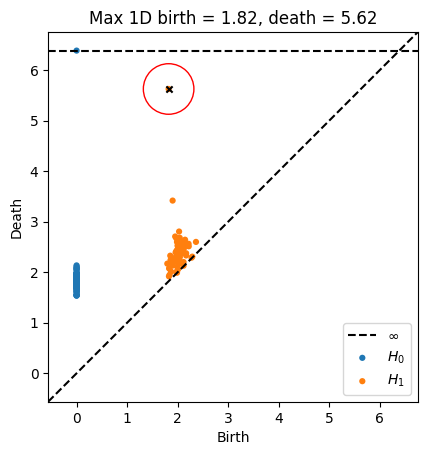

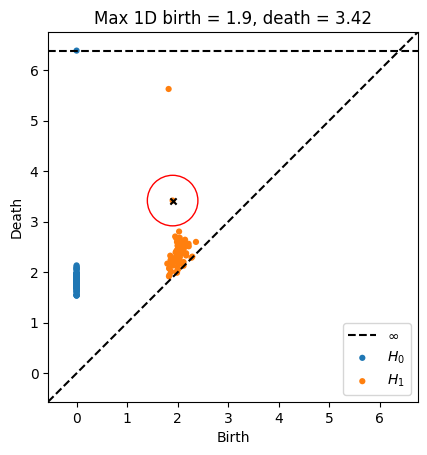

In [2]:
#This is just to get everything ready
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')
plt.show()
result = ripser(x, coeff=2, do_cocycles=True)
diagrams = result['dgms']
cocycles = result['cocycles'] #all of the cocycles
D = result['dperm2all'] #distance matrix between the ith and jth points in the data
dgm1 = diagrams[1]


#This is the start for the highest point in the persistence diagram
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.gca().add_patch(plt.Circle((dgm1[idx, 0], dgm1[idx, 1]), 0.5, color='r', fill=False))
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()
cocycle1 = cocycles[1][idx] #I think that this is the representative cocycle for the highest point

#Now we just have to find the representative cocycle for psi so we have to look for the second highest point
sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0])
idx = sorted_indices[-2] #this will give me the second highest persistent point
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.gca().add_patch(plt.Circle((dgm1[idx, 0], dgm1[idx, 1]), 0.5, color='r', fill=False))
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()
cocycle2 = cocycles[1][idx] #I think that this is the representative cocyle for the second highest persistent point

In [3]:
#For cocycle1 we want to restrict it to cocycle2


New_cocycle1=[]
edges=[]
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i:i-1, :2], cocycle1[i:i+1, :2], cocycle2[j:j+1, :2]): #This checks to see if there are any edges in common 
                New_cocycle1.append(cocycle2[j:j+1])
        New_cocycle1.append(cocycle2[i:i+1])        
rcocycle1=np.vstack(New_cocycle1)

#Now I have to go back to collect the edges in common:

for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i-1:i, :2], cocycle2[j:j+1, :2]):
                edges.append(cocycle2[j:j+1])
                
edges=np.vstack(edges)



#Finally I have to make the rows that are not equal to any of the edges columns be zero
for i in range(len(rcocycle1)):
    found_match = False

    for j in range(len(edges)):
        if np.array_equal(rcocycle1[i, :2], edges[j, :2]):
            found_match = True
            break

    if not found_match:
        rcocycle1[i, -1] = 0

#Checking to see if the dimensions are correct
print("Length of Restricted Cocycle 1")            
print(len(rcocycle1))
print("Length of Cocycle 2")
print(len(cocycle2))
print("Edges that are in common")
print(len(edges))

Length of Restricted Cocycle 1
97
Length of Cocycle 2
97
Edges that are in common
5


In [4]:
#Ok ok now we can start taking the cup product

#so we have phi and psi, now we need to extract every traingle {a,b,c} then take phi(rcocycle1) of the first two {a,b} then psi(cocycle2) of the last two verticies {b,c}

#First we have to get all of the triangles:

# Finding the representative cocycles for triangles
from itertools import combinations

representative_cocycles = []

for i in range(len(dgm1)):
    birth, death = dgm1[i]
    if birth != death:  # ignore points on the diagonal
        cocycle = cocycles[1][i]
        representative_cocycles.append(cocycle)

# Extracting every triangle as an array of vertices
triangles = []

for cocycle in representative_cocycles:
    edge_indices = cocycle[:, :2].astype(int)
    triangle_vertices = set()
    
    for i, j in edge_indices:
        triangle_vertices.add(i)
        triangle_vertices.add(j)
    
    # Generate all combinations of 3 vertices
    triangle_combinations = combinations(triangle_vertices, 3)
    
    for combination in triangle_combinations:
        triangles.append(list(combination))


t=np.vstack(triangles)
print("Number of triangles we have to look through")
print(len(t))


Number of triangles we have to look through
77652


In [5]:
#Cup product function

def cupProduct(phi, psi, triangleList):
    cupProduct = []
    for i in range(len(triangleList)):
        phiVal = 0
        psiVal = 0
        for j in range(len(phi)):
            if phi[j][0] == triangleList[i][0] and phi[j][1] == triangleList[i][1]:
                phiVal = phi[j][2]
                break;
        for k in range(len(psi)):
            if psi[k][0] == triangleList[i][1] and psi[k][1] == triangleList[i][2]:
                psiVal = psi[k][2]
                break;
        cupProduct.append(phiVal * psiVal)
    cupProduct = np.array(cupProduct).T
    return cupProduct


In [6]:


cup=cupProduct(rcocycle1,cocycle2, t)
cup=np.vstack(cup)
print("Cup Product:")
print(cup)
print("Confirm dimension is the same")
print(len(cup))
time_e=time.time()-start_time
print("Time elasped")
print(time_e)

Cup Product:
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
Confirm dimension is the same
58504
Time elasped
10.570174932479858


In [7]:
#Try to compute the boundary matrix from ripser, going with the same approach that I had for gudhi but just not with gudhi
#Already got the triangles but will just do it again and extract all vertices, edges, and triangles

edges = []
triangles = []
vertices=[]

#Triangles

from itertools import combinations

representative_cocycles = []

for i in range(len(dgm1)):
    birth, death = dgm1[i]
    if birth != death:  # ignore points on the diagonal
        cocycle = cocycles[1][i]
        representative_cocycles.append(cocycle)

# Extracting every triangle as an array of vertices

for cocycle in representative_cocycles:
    edge_indices = cocycle[:, :2].astype(int)
    triangle_vertices = set()
    
    for i, j in edge_indices:
        triangle_vertices.add(i)
        triangle_vertices.add(j)
    
    # Generate all combinations of 3 vertices
    triangle_combinations = combinations(triangle_vertices, 3)
    
    for combination in triangle_combinations:
        triangles.append(list(combination))

# Extracting every edge as an array of vertices

for cocycle in representative_cocycles:
    edge_indices = cocycle[:, :2].astype(int)
    for i, j in edge_indices:
        edge = [i, j]
        edges.append(edge)
        
#Gettin the vertices
for cocycle in representative_cocycles:
    vertex_indices = cocycle[:, :1].astype(int)
    for i in vertex_indices:
        vertices.append(i[0])
        
# Remove duplicate vertices by converting the list to a set and then back to a list
vertices = list(set(vertices))
        
print("Vertices")
print(vertices)
print("Length of vertices")
print(len(vertices))
print("Edges")
print(edges)
print("Length of edges")
print(len(edges))
print("Triangles")
#print(triangles) #This is too long to print 
print("Length of triangles")
print(len(triangles))


Vertices
[9, 12, 13, 14, 17, 18, 20, 21, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Length of vertices
77
Edges
[[72, 71], [72, 58], [96, 72], [72, 42], [90, 23], [98, 90], [90, 48], [90, 6], [24, 16], [77, 33], [65, 33], [62, 36], [76, 62], [80, 13], [59, 13], [13, 1], [50, 3], [97, 3], [33, 15], [85, 33], [33, 8], [52, 49], [97, 19], [48, 19], [84, 10], [42, 10], [85, 8], [33, 15], [85, 33], [59, 17], [46, 17], [74, 3], [62, 3], [30, 3], [88, 47], [98, 47], [57, 52], [33, 15], [85, 33], [57, 8], [33, 8], [90, 19], [97, 19], [90, 23], [48, 19], [98, 90], [40, 19], [98, 69], [69, 19], [88, 47], [98, 88], [88, 78], [80, 71], [80, 24], [80, 36], [60, 11], [60, 44], [89, 60], [67, 44], [62, 30], [74, 3], [62, 3], [62, 9], [62, 36], [76, 62], [74, 36], [72, 27]

In [8]:
#Aight now that I have that, we can contruct the boundary matrix

#Create a boundary Matrix        
ne = len(edges)
nt = len(triangles)
nv = len(vertices)

num_rows= ne+nt+nv
num_cols=ne+nt+nv

boundary_matrix=np.zeros((num_rows, num_cols), dtype=int)


#Split it up and just deal with the edges and verticies first because the triangles are going to zero out, same will happen with the edges and edges and verticies and verticies

for i,edge in enumerate(edges):
    a,b=edge #a and b are the two verticies that make up the edge
    for j,vertex in enumerate(vertices):
        c=vertex # c d and e are the verticies that make up the triangle
        if b == c:
            boundary_matrix[nv+i,j]=1
        if a == c:
            boundary_matrix[nv+i,j]=-1
        
        
#now deal with the edges and verticies
for i, triangle in enumerate(triangles):
    e,f,g=triangle #e,f,g are verticies in the triangle
    for j,edge in enumerate(edges):
        h,k=edge
        if (h,k) == (e,f):
            boundary_matrix[(ne+nv)+i,nv+j]=1
        if (h,k) == (f,g):
            boundary_matrix[(ne+nv)+i,nv+j]=1
        if (h,k) == (e,g):
            boundary_matrix[(ne+nv)+i,nv+j]=-1

print("Boundary Matrix:")
boundary_matrix=boundary_matrix.T
print(boundary_matrix)
print(len(boundary_matrix))
print(len(boundary_matrix[0]))  

Boundary Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
59074
59074


In [9]:
restricted_matrix = boundary_matrix[nv:nv + ne, nv + ne:len(boundary_matrix)]
coboundary_matrix = np.flip(restricted_matrix).T
print("Coboundary Matrix")
print(coboundary_matrix)

Coboundary Matrix
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... -1  0  0]
 [ 0  0  0 ...  0  1 -1]]


In [10]:
print("Number of rows (triangles)")
print(len(coboundary_matrix))
print("Number of columns (edges)")
print(len(coboundary_matrix[0]))

Number of rows (triangles)
58504
Number of columns (edges)
493


In [11]:
len(cup)

58504

In [12]:
# Row Detection Algorithm
# Inputs: n x m matrix A, n x 1 vector b
# Outputs: Row in which matrix no longer has a solution (going bottom up)
# Call: rowDetect(A, b) (checkSolution is only defined to be used inside of that function)

def checkSolution(A, b):
    # Calculate the rank of the augmented matrix [A | b]
    augmented_matrix = np.column_stack((A, b))
    rank_A = np.linalg.matrix_rank(A)
    rank_augmented = np.linalg.matrix_rank(augmented_matrix)
    num_columns = A.shape[1]
    num_rows = A.shape[0]

    if rank_A == rank_augmented:
        if rank_A == num_columns:
            return 1
        elif rank_A < num_columns:
            return 1
    else:
        if rank_A < rank_augmented:
            return 0
    
    return "Unable to determine the solution status."

def rowDetect(A, b):
    for i in range(1, len(A) + 1):
        sol = checkSolution(A[-i:], b[-i:])
        if sol == 0:
            row = len(A) - i
            break;
    return row

In [13]:
rowDetect(coboundary_matrix, cup)

KeyboardInterrupt: 